In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

from utils.notebook_utils.dataframe_helper import load_candidate_dataframes, mark_sentence

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

In [4]:
CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])

In [5]:
def tag_sentence(x):
    candidates=(
        session
        .query(CompoundDisease)
        .filter(CompoundDisease.id.in_(x.candidate_id.astype(int).tolist()))
        .all()
    )
    tagged_sen=[
         " ".join(
             mark_sentence(
                candidate_to_tokens(cand), 
                [
                        (cand[0].get_word_start(), cand[0].get_word_end(), 1),
                        (cand[1].get_word_start(), cand[1].get_word_end(), 2)
                ]
            )
         )
        for cand in candidates
    ]

    return tagged_sen

In [6]:
spreadsheet_names = {
    #'train': '../data/sentences/sentence_labels_train.xlsx',
    'dev': '../data/sentences/sentence_labels_dev.xlsx',
    'test': '../data/sentences/sentence_labels_test.xlsx'
}

In [7]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_ctd")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [8]:
dev_predictions_df = pd.read_table("results/before_22_sampled_lfs.tsv_dev.tsv")
dev_predictions_df.columns = ["model_predictions", "candidate_id"]
dev_predictions_df.head(2)

,model_predictions,candidate_id
0,0.217591,65897
1,0.117172,65932


In [9]:
model_predictions_df = (
    candidate_dfs['dev']
    .merge(dev_predictions_df)
    [["curated_ctd", "model_predictions", "candidate_id"]]
    .round(2)
)
model_predictions_df.head(2)

,curated_ctd,model_predictions,candidate_id
0,0.0,0.22,65897
1,0.0,0.12,65932


In [10]:
dev_all_predictions_df = pd.read_table("results/after_22_sampled_lfs.tsv_dev.tsv")
dev_all_predictions_df.columns = ["candidate_id", "model_predictions_after"]
dev_all_predictions_df.head(2)

,candidate_id,model_predictions_after
0,65897,0.452902
1,65932,0.426005


In [11]:
total_candidates_df = pd.read_csv("../dataset_statistics/results/all_ctd_map.tsv.xz", sep="\t")
total_candidates_df.head(2)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,doid_id,doid_name,resource,resource_id,drugbank_id,drug_name,disease,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,DOID:2531,hematologic cancer,CSP,2004-1600,DB00007,Leuprolide,NaN,NaN,0,6,1,0.58699,9,1.0,1.0,0.0,77006168,Follicular mucinosis and mycosis-fungoides-lik...,16,26220260
1,DOID:2531,hematologic cancer,CSP,2004-1600,DB00007,Leuprolide,NaN,NaN,0,6,1,0.58699,9,1.0,1.0,0.0,77006178,We report an unusual case of disseminated urti...,35,26208290


In [12]:
confidence_score_df = (
    total_candidates_df
    [["drug_name", "doid_name", "text", "candidate_id"]]
    .merge(dev_predictions_df, on="candidate_id")
    .merge(dev_all_predictions_df, on="candidate_id")
    .sort_values("candidate_id")
    .assign(text=lambda x: tag_sentence(x))
    .sort_values("model_predictions_after")
)
confidence_score_df.head(2)

,drug_name,doid_name,text,candidate_id,model_predictions,model_predictions_after
223,Dobutamine,coronary artery disease,two-dimensional echocardiography can detect re...,650620,0.002075,0.286629
97,Cyclic Adenosine Monophosphate,ovarian cancer,the hormonal regulation of steroidogenesis and...,79453,0.002475,0.291989


In [13]:
(
    confidence_score_df
    .head(10)
    .sort_values("model_predictions_after", ascending=False)
    .drop("candidate_id", axis=1)
    .round(3)
    .to_csv("results/bottom_ten_high_confidence_scores.tsv", sep="\t", index=False)
)

In [14]:
(
    confidence_score_df
    .tail(10)
    .sort_values("model_predictions_after", ascending=False)
    .drop("candidate_id", axis=1)
    .round(3)
    .to_csv("results/top_ten_high_confidence_scores.tsv", sep="\t", index=False)
)

In [15]:
model_all_predictions_df = (
    candidate_dfs['dev']
    .merge(dev_all_predictions_df.rename(index=str, columns={"model_predictions_after":"model_predictions"}))
    [["curated_ctd", "model_predictions"]]
    .round(2)
)
model_all_predictions_df.head(2)

,curated_ctd,model_predictions
0,0.0,0.45
1,0.0,0.43


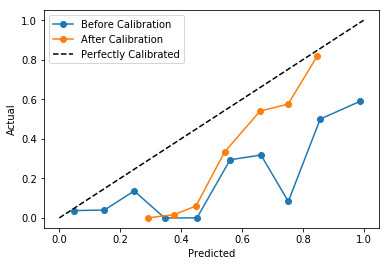

In [16]:
from sklearn.calibration import calibration_curve
cnn_y, cnn_x = calibration_curve(model_predictions_df.curated_ctd, model_predictions_df.model_predictions, n_bins=10)
all_cnn_y, all_cnn_x = calibration_curve(model_predictions_df.curated_ctd, model_all_predictions_df.model_predictions, n_bins=10)

plt.plot(cnn_x, cnn_y, marker='o', label="Before Calibration")
plt.plot(all_cnn_x, all_cnn_y, marker='o', label="After Calibration")

plt.plot([0,1], [0,1], color='black', linestyle='--', label="Perfectly Calibrated")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.legend()